<H2> scDRS Trial </H2>
Based on the <a href="https://martinjzhang.github.io/scDRS/notebooks/quickstart.html">tutorial</a> provided by the tools' creators.

In [1]:
# Imports
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
import anndata
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path("../Data/SCDRS")

h5ad_files = [
    DATA_DIR / "multiome" / "Mono_subset_UT.h5ad",
    DATA_DIR / "multiome" / "CD4_T_subset_UT.h5ad"
]

geneset = DATA_DIR / "genesets" / "GS_SLE-T1D_W20,5_OC.gs"

In [3]:
adata = anndata.concat([
    scdrs.util.load_h5ad(
        h5ad_file=file, flag_filter_data=True, flag_raw_count=True
    ) for file in h5ad_files
])

adata.obs_keys()

['orig.ident',
 'nCount_RNA_v5',
 'nFeature_RNA_v5',
 'nCount_RNA',
 'nFeature_RNA',
 'barcode',
 'barcode_1',
 'barcode_lane',
 'lane',
 'batch',
 'percent.mt',
 'nCount_RNA_mad',
 'nFeature_RNA_mad',
 'confined_best_match_sample',
 'confined_second_match_sample',
 'confined_best_match_correlation',
 'confined_second_match_correlation',
 'confined_condition',
 'unconfined_best_match_sample',
 'unconfined_second_match_sample',
 'unconfined_best_match_correlation',
 'unconfined_second_match_correlation',
 'unconfined_condition',
 'soup_cluster',
 'soup_status',
 'soup_singlet_posterior',
 'soup_doublet_posterior',
 'soup_log_prob_singleton',
 'soup_log_prob_doublet',
 'soup_cluster0',
 'soup_cluster1',
 'soup_cluster2',
 'soup_cluster3',
 'soup_cluster4',
 'soup_cluster5',
 'soup_cluster6',
 'soup_cluster7',
 'sample_final',
 'final_condition',
 'predicted.mo_10x_cell_type',
 'predicted.mo_10x_cell_type.score',
 'predicted.mo_10x_cell_type.lowerres',
 'nCount_SCT',
 'nFeature_SCT',
 'SC

In [4]:
adata.obs["sample_final"].unique()

array(['MO302', 'MO153', 'MO194', 'MO217', 'MO215'], dtype=object)

In [5]:
# Cell types
adata.obs[['predicted.mo_10x_cell_type.lowerres', 'predicted.mo_10x_cell_type', "celltype_imputed_lowerres", 'celltype_imputed']]

,predicted.mo_10x_cell_type.lowerres,predicted.mo_10x_cell_type,celltype_imputed_lowerres,celltype_imputed
CTAAGTCAGGGTGAAC_230105_lane1,NK,NK,monocyte,CD14 Mono
CTGTTGGAGTGACCTG_230105_lane1,NK,NK,monocyte,CD14 Mono
AGCACAGCACTCAACA_230105_lane1,unannotated,unannotated,monocyte,CD14 Mono
CATATCGCACAACCTA_230105_lane1,unannotated,unannotated,monocyte,CD14 Mono
TTAGAAGCAAGATTCT_230105_lane1,unannotated,unannotated,monocyte,CD14 Mono
...,...,...,...,...
ACGTTACAGAAACTGG_230316_lane8,CD4T,CD4 Naive,CD4T,CD4 TCM
GAAAGCCAGTGAACCT_230316_lane8,CD4T,CD4 TCM,CD4T,CD4 Naive
ACTTAGGGTAATAACC_230316_lane8,unannotated,unannotated,CD4T,CD4 Naive
CGGCCATAGGAGTAAT_230316_lane8,unannotated,unannotated,CD4T,CD4 TCM


In [6]:
# Covariate file - OPTIONAL

# covariate_file = DATA_DIR / "multiome" / "covariates.tsv" 
# cov_data = adata.obs[["SEX", "age", "n_genes"]].copy()
# cov_data.to_csv(covariate_file, sep="\t", index=True)

In [7]:
# load geneset, convert homologs and overlap gene names to adata.var_names
dict_gs = scdrs.util.load_gs(
    geneset,
    src_species="human",
    dst_species="human",
    to_intersect=adata.var_names,
)

mouse_height = scdrs.util.load_gs(
    "..\\Data\\SCDRS\\tutorial\\mouse_height.gs",
    src_species="mouse",
    dst_species="human",
    to_intersect=adata.var_names,
)

# Merge dicts
dict_gs = dict_gs | mouse_height

# load covariates
df_cov = adata.obs[["SEX", "age", "n_genes"]].copy()


In [8]:
# Preprocess data
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

c:\Users\hesse\mambaforge\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\hesse\AppData\Local\Temp\ipykernel_25184\2098157408.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=14


In [9]:
# Assign cell scores for each trait
dict_df_score = dict()
for trait in dict_gs:
    gene_list, gene_weights = dict_gs[trait]
    dict_df_score[trait] = scdrs.score_cell(
        data=adata,
        gene_list=gene_list,
        gene_weight=gene_weights,
        ctrl_match_key="mean_var",
        n_ctrl=1000,
        weight_opt="vs",
        return_ctrl_raw_score=False,
        return_ctrl_norm_score=True,
        verbose=False,
    )

Computing control scores: 100%|██████████| 1000/1000 [00:30<00:00, 32.60it/s]


In [10]:
dict_df_score.keys()
min(dict_df_score["SLE"].norm_score)

-2.7374823093414307

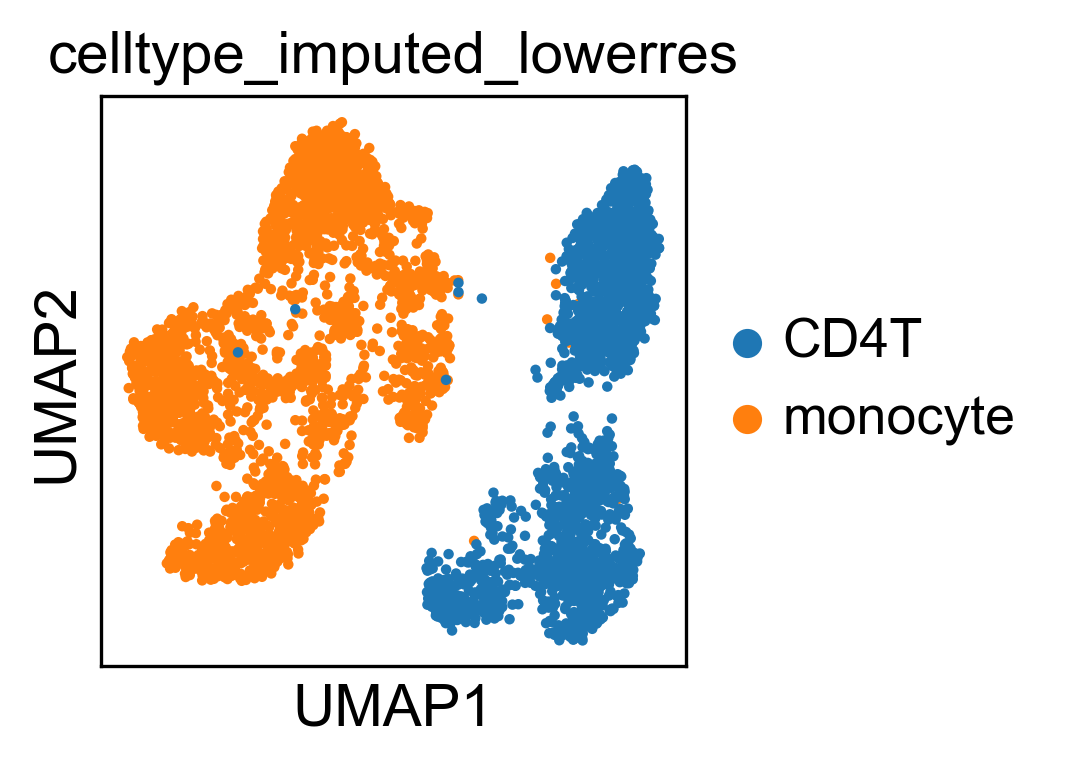

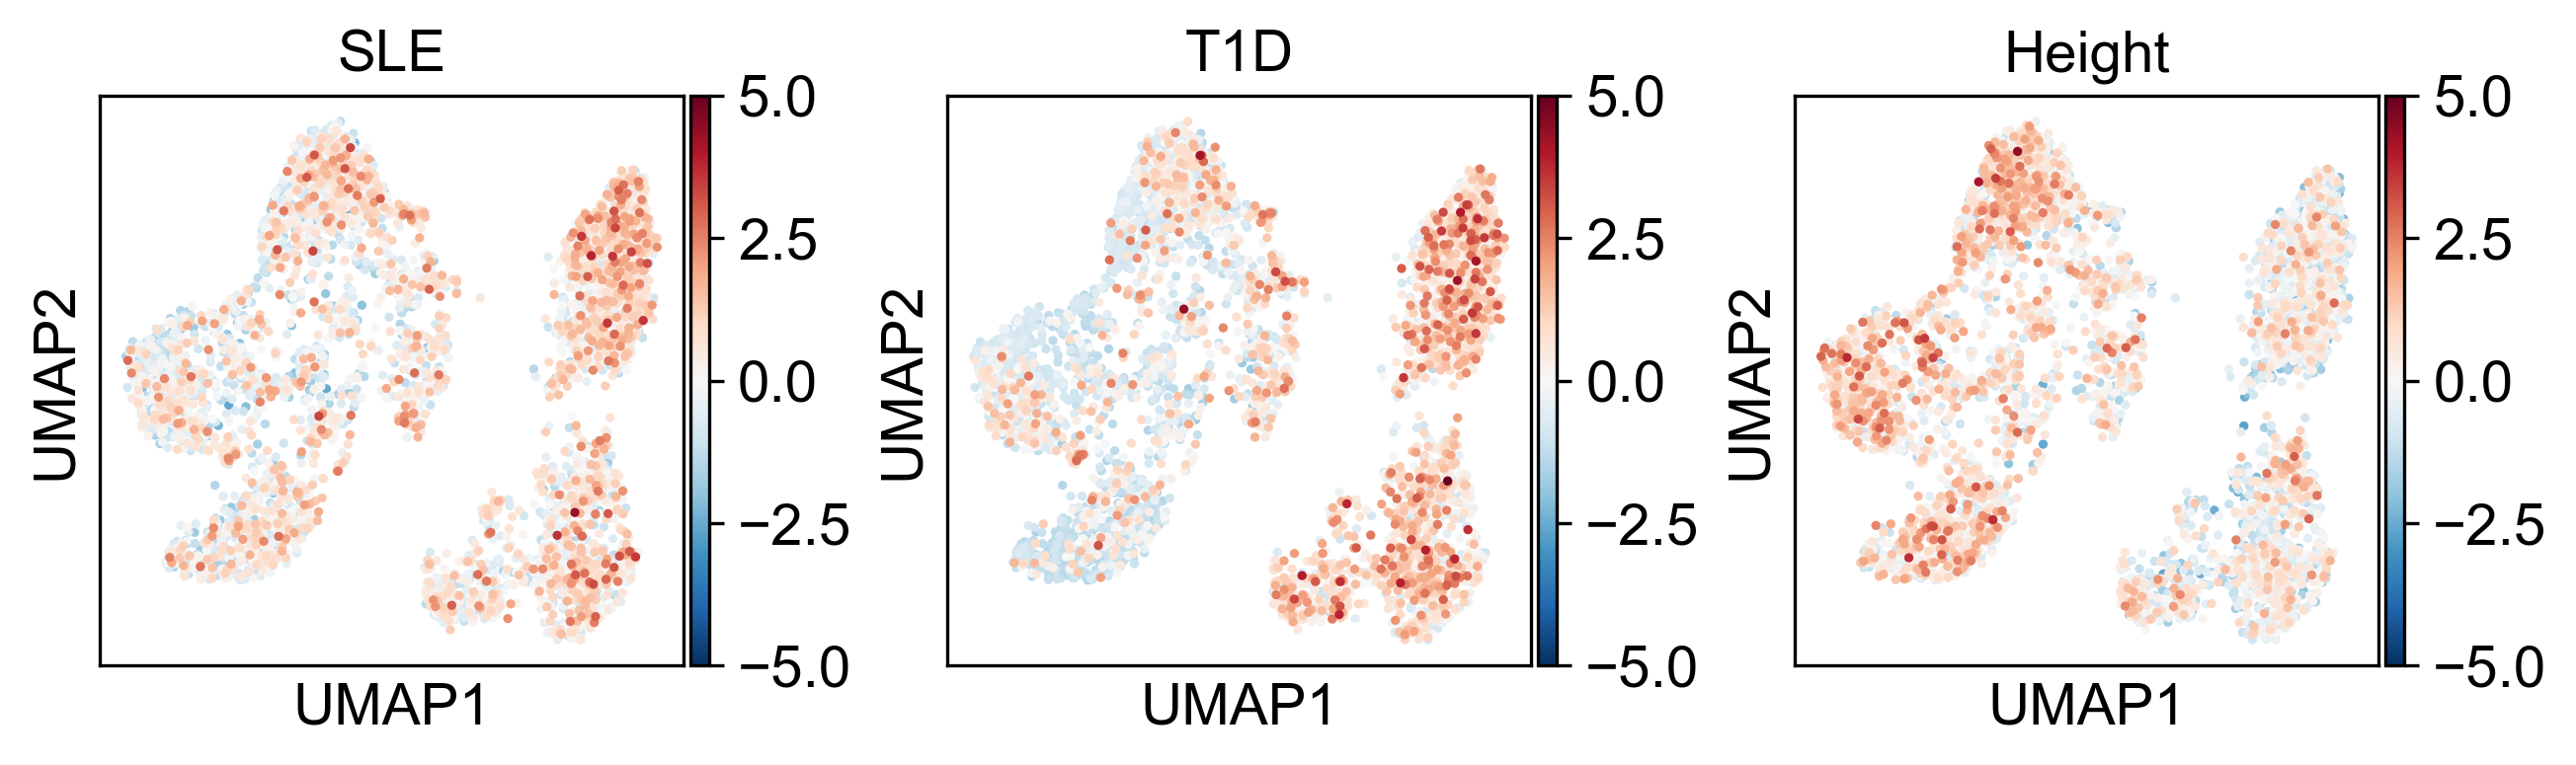

In [11]:
# NOTE: predicted.mo_10x_cell_type.lowerres, celltype_imputed_lowerres, celltype_imputed
for trait in dict_df_score:
    adata.obs[trait] = dict_df_score[trait]["norm_score"]

sc.set_figure_params(figsize=[2.5, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color="celltype_imputed_lowerres",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_df_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
)

In [12]:
# predicted.mo_10x_cell_type.lowerres, celltype_imputed_lowerres, celltype_imputed
group = "celltype_imputed_lowerres"

for trait in dict_df_score.keys():
    df_stats = scdrs.method.downstream_group_analysis(
        adata=adata,
        df_full_score=dict_df_score[trait],
        group_cols=[group],
    )[group]

    display(df_stats.style.set_caption(f"Group-level statistics for {trait}"))

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
CD4T,2056.000000,1000.000000,0.214785,0.786238,0.086913,1.297982,0.000000,0.000000,0.000000
monocyte,2687.000000,1000.000000,0.674326,-0.536346,0.328671,0.368918,0.000000,0.000000,0.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
CD4T,2056.000000,1000.000000,0.025974,1.757553,0.550450,-0.280352,0.000000,1.000000,1.000000
monocyte,2687.000000,1000.000000,0.831169,-0.941816,0.070929,1.534458,0.000000,0.000000,0.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
CD4T,2056.000000,1000.000000,0.949051,-1.638510,0.251748,0.701647,0.000000,0.000000,0.000000
monocyte,2687.000000,1000.000000,0.052947,1.732812,0.642358,-0.461251,0.000000,0.000000,0.000000


1. assoc_mcp: significance of cell type-disease association

2. hetero_mcp: significance heterogeneity in association with disease across individual cells within a given cell type

3. n_fdr_0.1: number of significantly associated cells (with FDR0.1 across all cells for a given disease)

In [13]:
# Save results
